In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
from datetime import datetime

import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

# Gensim/Spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel 
import spacy

from src.text.utils import *
from src.text.lda import *
from src.text.epu import EPU

In [2]:
target = os.getcwd() + "/data/text/solomon_islands/"
news_path = [
    target + filename for filename in os.listdir(target)
    if "news" in filename and "ner" not in filename
]

In [3]:
def convert_datetime_format(date_str):
    try:
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        # Convert it to the desired format
        return date_obj.strftime('%Y-%m-%d')
    except ValueError:
        return None

## LDA (mallet)

In [4]:
en = spacy.load('en_core_web_sm')
spacy_stopwords = list(en.Defaults.stop_words)

In [6]:
nltk_stopwords = stopwords.words("english")
nltk_unique = [sw for sw in nltk_stopwords if sw not in spacy_stopwords]
spacy_stopwords.extend(nltk_unique)

In [7]:
spacy_stopwords.extend(["say", "year", "country", "issue", "island"])

In [8]:
epu = EPU(news_path, cutoff=None)
epu.get_epu_category()

In [9]:
news = pd.DataFrame()
for _, df in epu.raw_files:
    temp = df[df.econ & df.policy].reset_index(drop=True)[["date", "url", "news"]]
    if news.empty:
        news = temp
    else:
        news = pd.concat([news, temp], axis=0)

In [10]:
data = news.news.values.tolist()
data_words = list(sent_to_words(data))

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

bigram = gensim.models.Phrases(data_words, min_count=10, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], min_count=10, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_preprocessed = preprocess_text(data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [13]:
id2word = corpora.Dictionary(texts_preprocessed)
texts = texts_preprocessed
corpus = [id2word.doc2bow(text) for text in texts]

In [14]:
from gensim.models.wrappers import LdaMallet
mallet_path = os.getcwd() + '/../mallet-2.0.8/bin/mallet'
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=texts_preprocessed,
                                                        mallet_path=mallet_path,
                                                        start=2,
                                                        limit=20,
                                                        step=1)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 2635
total tokens: 1382841
<10> LL/token: -8.32913
<20> LL/token: -8.08131
<30> LL/token: -7.92566
<40> LL/token: -7.87721

0	25	government business people public member provincial time company police report add week parliament good issue statement yesterday day officer give 
1	25	government development support project economic work include island community provide people policy country national woman sector economy opportunity area ensure 

<50> LL/token: -7.85681
<60> LL/token: -7.84482
<70> LL/token: -7.83761
<80> LL/token: -7.83333
<90> LL/token: -7.83176

0	25	government business people public provincial member time company report police add week parliament give good statement day follow yesterday issue 
1	25	government development support project economic work island include provide community people policy country national woman sector economy ensure opportunity important 

<100> LL/token: -7.82926
<110> LL

<910> LL/token: -7.81244
<920> LL/token: -7.81231
<930> LL/token: -7.81275
<940> LL/token: -7.81234

0	25	government business people public provincial member time company report police week add parliament good give follow statement issue yesterday land 
1	25	government development support project economic work include island community provide people policy country woman national sector economy important opportunity area 

<950> LL/token: -7.81199
<960> LL/token: -7.81096
<970> LL/token: -7.81097
<980> LL/token: -7.8124
<990> LL/token: -7.81262

0	25	government business people public provincial member time company report police week add parliament good issue give follow statement yesterday land 
1	25	government development support project economic work island include community provide people policy country woman national sector economy ensure area important 

<1000> LL/token: -7.81289

Total time: 40 seconds
Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 2635

<610> LL/token: -7.91206
<620> LL/token: -7.91259
<630> LL/token: -7.91244
<640> LL/token: -7.91115

0	16.66667	government public business company provincial police member report parliament time officer yesterday statement decision medium pay law add money week 
1	16.66667	government development project economic support national policy provide include sector service economy ensure increase improve plan infrastructure fund budget investment 
2	16.66667	people work community woman island business year leader local support opportunity visit good australian nation tourism security time continue family 

<650> LL/token: -7.91134
<660> LL/token: -7.91153
<670> LL/token: -7.91301
<680> LL/token: -7.9119
<690> LL/token: -7.91177

0	16.66667	government public business company member provincial police parliament report officer statement yesterday time decision pay week add law follow issue 
1	16.66667	government development project economic support policy national include provide sector service 

<210> LL/token: -7.99027
<220> LL/token: -7.98875
<230> LL/token: -7.98681
<240> LL/token: -7.9853

0	12.5	project people work support province community service provincial local provide area health infrastructure rural government market improve fund plan include 
1	12.5	government economic economy budget policy sector increase business investment national finance financial growth tourism add current report industry expect ensure 
2	12.5	company business police public member people officer pay law money medium case call order yesterday time give report issue payment 
3	12.5	development support country island woman economic people leader opportunity develop work region include address partner nation challenge important regional security 

<250> LL/token: -7.98553
<260> LL/token: -7.985
<270> LL/token: -7.98367
<280> LL/token: -7.98188
<290> LL/token: -7.98275

0	12.5	project people support work province community service provincial local area provide health infrastructure rural market i

<760> LL/token: -7.9818
<770> LL/token: -7.98202
<780> LL/token: -7.98136
<790> LL/token: -7.9829

0	12.5	project people work support province community service local provincial area health provide rural covid market student family water infrastructure include 
1	12.5	government economic economy sector policy business increase budget investment growth national finance financial tourism fund report system industry service ensure 
2	12.5	government company business police public member parliament officer medium pay time law people money provincial case order yesterday decision call 
3	12.5	development support country woman island economic people opportunity leader develop include work region nation partner national address important regional security 

<800> LL/token: -7.98213
<810> LL/token: -7.98099
<820> LL/token: -7.98279
<830> LL/token: -7.98217
<840> LL/token: -7.98193

0	12.5	project people work support province community provincial service local area health rural covid provide ma

<260> LL/token: -8.03756
<270> LL/token: -8.03668
<280> LL/token: -8.03742
<290> LL/token: -8.03734

0	10	island country leader region visit include people nation economic tourism regional trade security meeting issue state international develop development global 
1	10	people business work woman community local increase opportunity market good economy industry education training percent high year support child islander 
2	10	people police covid health officer time week student day service public case water continue honiara situation yesterday operation today follow 
3	10	government project development support economic policy national fund sector province provide infrastructure budget plan service provincial ensure include rural improve 
4	10	government company member parliament public report provincial business pay land medium statement decision issue process payment law add log money 

<300> LL/token: -8.03837
<310> LL/token: -8.03766
<320> LL/token: -8.03717
<330> LL/token: -8.03719

<710> LL/token: -8.03357
<720> LL/token: -8.0336
<730> LL/token: -8.0329
<740> LL/token: -8.03297

0	10	island country leader people region economic visit include nation development regional issue meeting security trade develop state global address agreement 
1	10	business work woman people community local opportunity increase market tourism industry support education student training percent high good program child 
2	10	people police covid officer health time service week day water public case business honiara situation continue operation yesterday charge follow 
3	10	government project development support economic policy national province fund infrastructure provide budget sector provincial plan ensure service rural include improve 
4	10	government company member parliament public report provincial pay land medium statement business decision process payment issue law give money log 

<750> LL/token: -8.03445
<760> LL/token: -8.03399
<770> LL/token: -8.03499
<780> LL/token: -8.0345
<

<160> LL/token: -8.0878
<170> LL/token: -8.08516
<180> LL/token: -8.08404
<190> LL/token: -8.08209

0	8.33333	business service covid work health tourism time provide include week local road people public worker start day continue number good 
1	8.33333	government project support development province national provincial program infrastructure fund work community people rural area economic provide improve assistance plan 
2	8.33333	people government police land leader year time political good election medium concern nation call island interest group thing security decision 
3	8.33333	economy increase economic sector government budget growth market investment industry high financial resource water percent fishery export report local management 
4	8.33333	country woman region opportunity development island economic include develop policy work regional address meeting issue challenge leader member trade important 
5	8.33333	government company public member pay officer parliament report proc

<560> LL/token: -8.06316
<570> LL/token: -8.06375
<580> LL/token: -8.06261
<590> LL/token: -8.06294

0	8.33333	business service covid work people health local tourism time water community week provide family road day start include worker number 
1	8.33333	government project development support provincial national province program infrastructure fund work rural plan area improve provide people policy economic budget 
2	8.33333	government people police leader parliament year medium time good political decision member election nation interest concern state call group security 
3	8.33333	economy economic increase sector growth investment industry financial high percent resource report market fishery export local impact management agriculture product 
4	8.33333	country woman opportunity development region island include economic develop support regional meeting issue challenge trade work address leader important role 
5	8.33333	public company business officer government pay member process r

<960> LL/token: -8.05733
<970> LL/token: -8.05852
<980> LL/token: -8.05762
<990> LL/token: -8.05697

0	8.33333	business people covid work service health community time water local family week road start day tourism worker visit provide live 
1	8.33333	government project development support provincial national province fund infrastructure policy budget work rural provide program plan area improve economic ensure 
2	8.33333	government people parliament police leader member medium decision political time interest state nation election concern statement good continue year call 
3	8.33333	economy economic increase sector growth investment industry high market financial resource percent impact report fishery export local management cost agriculture 
4	8.33333	country woman opportunity development island region include support economic develop work meeting regional partnership challenge trade issue address event partner 
5	8.33333	public company business officer pay money report payment proce

<310> LL/token: -8.08734
<320> LL/token: -8.08745
<330> LL/token: -8.08727
<340> LL/token: -8.0864

0	7.14286	economic sector economy increase business investment growth market tourism industry resource percent high fishery service policy island export impact product 
1	7.14286	business company police officer pay money payment public court case order law receive claim operation charge yesterday matter mining give 
2	7.14286	government provincial member parliament public budget policy national province report statement finance add process current decision ministry bill financial service 
3	7.14286	woman community work support opportunity people education student training development program programme event business child role provide partnership important youth 
4	7.14286	people covid health time service water day food worker good week situation affect travel place honiara community border continue response 
5	7.14286	project development government support work land infrastructure fund 

<660> LL/token: -8.08042
<670> LL/token: -8.07795
<680> LL/token: -8.07833
<690> LL/token: -8.07841

0	7.14286	economic sector economy increase investment growth resource market tourism industry policy percent fishery high impact export sustainable local service agriculture 
1	7.14286	company business police officer pay money payment court public case land order operation law receive report claim charge mining yesterday 
2	7.14286	government provincial member public parliament budget national policy province add statement decision finance current election bill report process medium state 
3	7.14286	woman work community people business opportunity education support student training program event child role school youth islander important provide social 
4	7.14286	people covid health service time water worker day week community good situation place travel honiara month continue affect number family 
5	7.14286	development project government support work infrastructure provide plan fund ar

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 2635
total tokens: 1382841
<10> LL/token: -9.52995
<20> LL/token: -8.94496
<30> LL/token: -8.52165
<40> LL/token: -8.35427

0	6.25	government development project economic policy support budget infrastructure sector national investment economy growth ensure priority improve plan resource reform area 
1	6.25	government provincial province fund land service project financial provide finance system road people ministry payment western funding national receive report 
2	6.25	government member parliament people decision student medium statement leader political public election interest bill issue add group call corruption question 
3	6.25	people community covid health water increase impact food affect good high tax time risk situation report live day percent measure 
4	6.25	country island people visit region security leader regional nation australian trade assistance include agreement support official meeting coopera

<310> LL/token: -8.12015
<320> LL/token: -8.11947
<330> LL/token: -8.1199
<340> LL/token: -8.1201

0	6.25	government development economic policy sector budget economy ensure growth investment national financial improve key resource priority management strategy system sustainable 
1	6.25	government project provincial province fund support infrastructure land people development work service area rural provide national funding constituency road include 
2	6.25	government people member parliament decision statement public medium leader political election interest state bill call add issue concern good time 
3	6.25	increase report water percent impact people high fishery food health island export affect population global risk reduce price rate market 
4	6.25	country island region security leader visit regional trade meeting assistance nation official economic include agreement support meet people australian cooperation 
5	6.25	woman community support work opportunity people program educatio

<610> LL/token: -8.10611
<620> LL/token: -8.10715
<630> LL/token: -8.10731
<640> LL/token: -8.10922

0	6.25	government economic development policy sector budget economy growth financial ensure national investment key management system resource strategy provide finance reform 
1	6.25	government project provincial province fund support development infrastructure land people work rural area national funding constituency road provide community complete 
2	6.25	government member parliament people decision statement medium public leader political election add call interest state time bill concern issue question 
3	6.25	increase report market water percent high food fishery export impact people island product industry local affect population economy environment price 
4	6.25	country island region visit security leader regional include trade meeting support assistance official australian economic nation meet agreement cooperation state 
5	6.25	woman work community people opportunity support pr

<910> LL/token: -8.10668
<920> LL/token: -8.10607
<930> LL/token: -8.10621
<940> LL/token: -8.10577

0	6.25	government economic development policy sector budget economy growth financial ensure investment national support key management system strategy finance resource reform 
1	6.25	government project provincial province support fund development infrastructure land people work rural area national community funding constituency road provide plan 
2	6.25	government member parliament people decision statement medium leader public political election interest add state bill call concern time national good 
3	6.25	increase market water percent high report fishery industry export island food local impact product cost people economy population year resource 
4	6.25	country island region visit security regional include meeting leader trade economic official assistance meet support australian nation agreement issue state 
5	6.25	woman people work community opportunity program business support ed

<210> LL/token: -8.14859
<220> LL/token: -8.14668
<230> LL/token: -8.14453
<240> LL/token: -8.14259

0	5.55556	government economic policy sector economy budget development investment growth financial ensure national service reform finance public revenue system resource key 
1	5.55556	public police business officer order law court case charge yesterday corruption medium report matter high accuse office person vehicle money 
2	5.55556	market increase industry local high water fishery export food report island product percent cost agriculture resource impact log small price 
3	5.55556	people government time good year family add day work thing call live change leave lot speak child long give problem 
4	5.55556	woman support opportunity development community work program business training develop provide programme role education sustainable partnership promote youth achieve access 
5	5.55556	country leader island region security meeting visit regional state trade official economic agreement

<510> LL/token: -8.13266
<520> LL/token: -8.13073
<530> LL/token: -8.13052
<540> LL/token: -8.13052

0	5.55556	government economic policy economy sector budget growth financial development investment national ensure finance reform system service strategy public increase revenue 
1	5.55556	business police public officer order law court case charge corruption money office yesterday operation high accuse matter person follow operate 
2	5.55556	market increase water local industry high fishery export food report island product agriculture log resource percent impact small price cost 
3	5.55556	people government time year good leader family day medium call thing add change leave nation live long speak lot political 
4	5.55556	woman business opportunity work support community program development training provide education role programme event promote youth develop partnership encourage economic 
5	5.55556	country island region visit security regional leader meeting economic trade assistance 

<810> LL/token: -8.12898
<820> LL/token: -8.12891
<830> LL/token: -8.12812
<840> LL/token: -8.12843

0	5.55556	government economic policy economy sector budget growth financial development investment ensure national system finance reform service strategy increase key resource 
1	5.55556	business police company public officer order law court case operation money charge corruption operate yesterday pay accuse high matter person 
2	5.55556	market increase local water high fishery export industry food agriculture product island report resource log percent impact area management cost 
3	5.55556	people government time good year leader call nation thing day add medium family leave speak lot long political change place 
4	5.55556	woman business work opportunity community support program education training role provide event programme important promote youth child development encourage information 
5	5.55556	country island region economic development security visit include regional leader trade

<60> LL/token: -8.27954
<70> LL/token: -8.24704
<80> LL/token: -8.22566
<90> LL/token: -8.21044

0	5	development economic policy sector support opportunity investment growth program training improve business key economy strategy programme develop national agriculture achieve 
1	5	project support infrastructure development work fund service community provide government constituency rural area road funding build complete include improve facility 
2	5	covid health economy percent increase government worker revenue continue service remain pandemic expect economic cost response measure total impact month 
3	5	member leader interest government political state decision parliament election people statement group foreign minister nation deal chinese party concern corruption 
4	5	people time year family student good work child school live thing start week life leave add home ramsi long number 
5	5	business police company pay officer court case order money public charge claim law operation matter

<310> LL/token: -8.14214
<320> LL/token: -8.14185
<330> LL/token: -8.14275
<340> LL/token: -8.14256

0	5	development economic policy sector support business opportunity investment growth program training key strategy improve programme economy achieve develop provide launch 
1	5	project support infrastructure government development work fund service provide rural include constituency improve road area build funding community facility complete 
2	5	covid health economy percent increase continue service revenue remain pandemic expect economic response measure impact government high medical rate risk 
3	5	government member medium decision political interest leader statement election parliament concern group foreign deal chinese party people state call power 
4	5	people work year time family student child school good start education thing life live number week islander home australian worker 
5	5	business company police officer pay court case order money public operation law charge matter y

<560> LL/token: -8.14563
<570> LL/token: -8.1455
<580> LL/token: -8.14583
<590> LL/token: -8.14304

0	5	development policy economic sector support business growth opportunity investment key ensure economy programme strategy develop national achieve improve training provide 
1	5	project support infrastructure government development provide service work fund rural improve constituency road include area plan funding community build facility 
2	5	covid health economy increase percent service continue revenue impact remain pandemic measure response economic expect situation government affect risk rate 
3	5	government medium decision political member interest statement people election leader concern call parliament deal chinese foreign group corruption opposition minister 
4	5	people work family student education child time year school start worker islander event young good opportunity home job live life 
5	5	business company police officer court case public operation order law charge pay mo

<810> LL/token: -8.13969
<820> LL/token: -8.13962
<830> LL/token: -8.14135
<840> LL/token: -8.1413

0	5	development economic policy sector support business growth investment key economy ensure opportunity programme strategy develop government national achieve reform improve 
1	5	project support infrastructure development government service work rural provide fund improve include area constituency road community build funding facility complete 
2	5	covid health economy percent increase service continue impact revenue response pandemic measure remain time expect situation risk rate affect medical 
3	5	government medium decision political people member election concern parliament interest statement leader deal call chinese corruption opposition time power minister 
4	5	work people family education student training child school opportunity event time year program worker islander start youth job young home 
5	5	business company police officer court public case order operation law charge mon

<60> LL/token: -8.29082
<70> LL/token: -8.25751
<80> LL/token: -8.23289
<90> LL/token: -8.2181

0	4.54545	woman policy development sector economic develop sustainable strategy agriculture access support improve address management resource key stakeholder programme launch market 
1	4.54545	government economy land budget increase percent economic export investment growth log report financial high revenue reform tax industry mining sector 
2	4.54545	covid health community people water fishery food market pandemic area response village impact medical affect supply day include support local 
3	4.54545	project development support government infrastructure fund rural work provide service economic improve area plan include funding constituency road program assistance 
4	4.54545	police business officer case court order public charge operation yesterday accuse office high man law vehicle matter follow involve rsipf 
5	4.54545	country region island tourism economic trade include visit agreement r

<310> LL/token: -8.15863
<320> LL/token: -8.15999
<330> LL/token: -8.15833
<340> LL/token: -8.15726

0	4.54545	woman development policy sector economic sustainable management strategy develop ensure resource address support national key stakeholder achieve improve programme agriculture 
1	4.54545	government economy budget economic increase growth percent investment export industry sector log report high revenue reform mining expect tax price 
2	4.54545	covid health water food market community people fishery product pandemic response medical local day island farmer impact risk supply affect 
3	4.54545	project support development government infrastructure fund rural provide service work improve area include funding constituency economic program road plan deliver 
4	4.54545	police business officer court order case public law charge operation yesterday high accuse matter office man license involve vehicle report 
5	4.54545	country island region visit tourism trade regional economic include

<560> LL/token: -8.149
<570> LL/token: -8.14966
<580> LL/token: -8.14878
<590> LL/token: -8.14947

0	4.54545	development policy ensure sector management develop resource address economic national strategy system sustainable key plan support stakeholder improve achieve provide 
1	4.54545	government economy budget economic increase growth investment percent industry sector export report high revenue expect mining log rate price impact 
2	4.54545	covid health water market food community people fishery product local response farmer medical pandemic supply day risk disaster emergency time 
3	4.54545	project support development infrastructure government fund rural work provide improve service program area funding economic community include road constituency deliver 
4	4.54545	police business officer court case public order law operation charge company accuse high yesterday matter office follow license involve vehicle 
5	4.54545	country island region visit tourism regional trade include econo

<810> LL/token: -8.14713
<820> LL/token: -8.14758
<830> LL/token: -8.14799
<840> LL/token: -8.14831

0	4.54545	development policy ensure resource develop sector management national system sustainable strategy economic address support key plan stakeholder achieve provide programme 
1	4.54545	government economy economic increase budget growth sector industry percent investment export report high revenue expect impact financial price rate cost 
2	4.54545	covid health water food market community fishery product people local farmer response medical area supply pandemic disaster emergency day tuna 
3	4.54545	project support development infrastructure government rural fund work provide improve program service funding area include road economic community constituency assistance 
4	4.54545	business police company officer court case public operation order law charge log mining high accuse matter director yesterday license issue 
5	4.54545	country island region visit tourism regional trade meetin

<60> LL/token: -8.31807
<70> LL/token: -8.2882
<80> LL/token: -8.26899
<90> LL/token: -8.25498

0	4.16667	government provincial member province parliament national decision election leader bill statement political people executive minister meeting add opposition interest yesterday 
1	4.16667	development country economic support region island trade partnership regional opportunity include partner leader meeting cooperation issue security agreement strengthen develop 
2	4.16667	government visit student sign education school official week year work offer meet study staff include add team hold agreement open 
3	4.16667	tourism water fishery develop resource island sector agriculture sustainable food community environment industry world impact management area small international increase 
4	4.16667	covid health service people work support worker response provide pandemic travel border continue include time week medical day emergency ensure 
5	4.16667	pay payment court money officer case pub

<260> LL/token: -8.18435
<270> LL/token: -8.18408
<280> LL/token: -8.18325
<290> LL/token: -8.18257

0	4.16667	government provincial member province parliament national people decision statement election bill leader political executive minister western opposition yesterday add pass 
1	4.16667	country development economic island region regional trade meeting agreement leader support include cooperation sign partner opportunity security meet partnership issue 
2	4.16667	student visit year school education week work government number time add staff member study official start offer team meet month 
3	4.16667	tourism water fishery island food resource community agriculture world sustainable environment develop area impact sector industry management small people climate 
4	4.16667	covid health service people worker work pandemic response travel border provide time include support continue week medical day ship emergency 
5	4.16667	officer public pay payment court money case report charge cl

<460> LL/token: -8.17899
<470> LL/token: -8.17856
<480> LL/token: -8.17882
<490> LL/token: -8.17989

0	4.16667	government provincial member province parliament national people election decision statement bill leader political executive interest minister add western opposition pass 
1	4.16667	country development island economic region regional trade leader meeting agreement include cooperation support sign security official meet issue visit partnership 
2	4.16667	student year work week school education visit time start member number study staff add month team event end offer meet 
3	4.16667	tourism water fishery island community food resource agriculture sustainable world environment area impact develop small people management industry high increase 
4	4.16667	covid health service people worker response border continue provide time work support pandemic include week travel medical ship day situation 
5	4.16667	public officer pay payment court case money report claim charge matter office

<660> LL/token: -8.17805
<670> LL/token: -8.18123
<680> LL/token: -8.17972
<690> LL/token: -8.1813

0	4.16667	government provincial province member parliament people national statement decision election leader bill political western executive interest add opposition yesterday minister 
1	4.16667	country island region economic regional trade development meeting leader include agreement support visit cooperation meet security sign official issue state 
2	4.16667	student work week year school education number visit member time start month staff study end add offer official receive meet 
3	4.16667	tourism water fishery island community food resource agriculture environment world area impact develop people sustainable management climate industry high increase 
4	4.16667	covid health service worker people response provide border time continue public include travel day pandemic medical ship week work situation 
5	4.16667	public officer pay payment court money case report charge matter claim o

<860> LL/token: -8.18194
<870> LL/token: -8.18331
<880> LL/token: -8.18336
<890> LL/token: -8.18376

0	4.16667	government provincial member province parliament national people statement election decision bill leader political executive add interest western opposition premier state 
1	4.16667	country island region regional trade economic leader meeting agreement visit development include support meet cooperation official sign security issue state 
2	4.16667	work student week education year school time start number visit month staff member study end offer team receive good hold 
3	4.16667	tourism water island fishery food community area environment impact resource agriculture world management develop small people sustainable climate increase tuna 
4	4.16667	covid health service people worker public response border continue time include provide pandemic travel medical ship ensure day week situation 
5	4.16667	public officer payment pay court report money case charge claim matter office re

<60> LL/token: -8.32917
<70> LL/token: -8.2993
<80> LL/token: -8.27919
<90> LL/token: -8.26176

0	3.84615	country region development economic trade meeting regional develop cooperation partnership meet agreement include opportunity global island issue leader partner discuss 
1	3.84615	woman work opportunity student training education child business school community event youth family program people young job skill study support 
2	3.84615	covid health tourism service travel border week pandemic response time include continue international medical government ship number day emergency month 
3	3.84615	people business time local water thing honiara call good happen family leave damage lot problem place village run find live 
4	3.84615	economy increase growth economic percent market sector high product revenue cost export agriculture investment expect total price rate grow farmer 
5	3.84615	project infrastructure work government road development provide build service include complete facil

<260> LL/token: -8.19661
<270> LL/token: -8.19337
<280> LL/token: -8.19438
<290> LL/token: -8.19471

0	3.84615	country region visit economic meeting trade island regional meet development agreement leader include cooperation official opportunity partnership issue state sign 
1	3.84615	woman work opportunity student training education child program community business school event youth family people young support worker job skill 
2	3.84615	covid health tourism service response border travel pandemic continue medical week support ship international include time government team provide emergency 
3	3.84615	people time water business local thing honiara leave village problem family good day live area start home call damage disaster 
4	3.84615	economy increase growth economic percent market sector high product industry revenue cost export investment agriculture price rate expect farmer total 
5	3.84615	project infrastructure work support government fund provide service road build include c

<460> LL/token: -8.1939
<470> LL/token: -8.19381
<480> LL/token: -8.19233
<490> LL/token: -8.19334

0	3.84615	country visit region meeting trade regional meet economic island leader agreement official include cooperation opportunity issue sign discuss development discussion 
1	3.84615	woman work opportunity student training education business program community child event youth school young family people support worker study skill 
2	3.84615	covid health tourism service response border travel week pandemic continue include support time medical ship international team ensure emergency operation 
3	3.84615	people water time business local family thing village report leave good honiara home area problem call live damage day start 
4	3.84615	economy increase growth economic sector market percent industry high product export investment business agriculture revenue grow cost price rate farmer 
5	3.84615	project infrastructure work support government provide service fund road build include fa

<660> LL/token: -8.1957
<670> LL/token: -8.19523
<680> LL/token: -8.19491
<690> LL/token: -8.19568

0	3.84615	country visit region meeting economic official trade regional meet include leader island agreement opportunity cooperation state sign issue development hold 
1	3.84615	woman work opportunity student training education business community program child event school youth support young family people worker skill study 
2	3.84615	covid health tourism service response travel support border continue pandemic time medical week include ensure provide international day ship emergency 
3	3.84615	people water time local family live honiara village leave thing report area business home community place affect day problem good 
4	3.84615	economy increase economic market industry percent growth sector business high product export investment agriculture grow price rate expect farmer cost 
5	3.84615	project infrastructure support work provide government service fund road build include improve a

<860> LL/token: -8.1975
<870> LL/token: -8.19809
<880> LL/token: -8.19984
<890> LL/token: -8.19905

0	3.84615	country visit meeting meet official region island leader trade agreement include economic cooperation regional sign issue opportunity hold development member 
1	3.84615	woman work business opportunity student training education program community child event youth school young support family worker skill study learn 
2	3.84615	covid health tourism service response continue support border pandemic travel week provide include medical time ensure day team emergency international 
3	3.84615	people water time family leave village home local honiara good live thing year problem day damage area call start affect 
4	3.84615	economy increase economic industry market percent growth sector business product high export investment agriculture grow price rate cost local farmer 
5	3.84615	project support infrastructure work provide service government fund road build community access include im

<60> LL/token: -8.3347
<70> LL/token: -8.29821
<80> LL/token: -8.27516
<90> LL/token: -8.2566

0	3.57143	work student business training school education worker australian visit event family staff program opportunity start week study team skill number 
1	3.57143	financial finance report public percent cost service increase reform revenue tax total system fund pay payment rate expect government spend 
2	3.57143	government provincial province national budget policy western add executive guadalcanal ministry premier ensure statement current propose process plan expenditure act 
3	3.57143	project support development infrastructure fund rural work provide funding constituency road improve assistance service area facility include program construction economic 
4	3.57143	parliament member election decision political bill leader chinese group opposition ramsi question government minister concern yesterday statement interest call confidence 
5	3.57143	sector economy market business tourism econo

<260> LL/token: -8.20324
<270> LL/token: -8.20191
<280> LL/token: -8.201
<290> LL/token: -8.20054

0	3.57143	work student education training program school australian event worker opportunity family study staff child skill week job start number learn 
1	3.57143	financial finance report percent public cost budget service fund increase total government tax revenue payment pay expect system money reform 
2	3.57143	government provincial province national policy western add budget ensure ministry process executive premier guadalcanal issue propose current statement plan consultation 
3	3.57143	project support development infrastructure fund rural work provide funding constituency improve road area government service facility program assistance build complete 
4	3.57143	parliament member decision election government political bill chinese statement opposition group ramsi question leader concern confidence minister interest yesterday deal 
5	3.57143	business sector market tourism economy indu

<460> LL/token: -8.19511
<470> LL/token: -8.19408
<480> LL/token: -8.19292
<490> LL/token: -8.19479

0	3.57143	work student education training program school australian event opportunity worker family child study week staff skill job learn number start 
1	3.57143	budget financial finance report government public percent cost service fund increase tax revenue total payment pay expect rate system estimate 
2	3.57143	government provincial province national policy add western ensure executive propose process issue premier guadalcanal current statement address ministry consultation plan 
3	3.57143	project development support infrastructure fund work rural constituency road provide improve funding service area include government program complete build facility 
4	3.57143	parliament member decision government election political bill chinese opposition statement ramsi interest group minister question confidence concern party power yesterday 
5	3.57143	business sector market tourism economy ind

<660> LL/token: -8.19259
<670> LL/token: -8.19215
<680> LL/token: -8.1939
<690> LL/token: -8.19339

0	3.57143	work education student training australian school program worker event child opportunity family study skill week staff young number start job 
1	3.57143	budget financial report finance government public percent cost fund payment service tax total revenue increase pay expect ministry rate system 
2	3.57143	government provincial province national policy add western ensure executive propose issue current premier address guadalcanal process consultation plan statement continue 
3	3.57143	project support development infrastructure fund rural work constituency road provide improve funding government area include program economic service facility complete 
4	3.57143	parliament member government decision election political bill group statement opposition ramsi interest question minister concern yesterday chinese medium confidence call 
5	3.57143	business sector market tourism industry 

<860> LL/token: -8.18865
<870> LL/token: -8.18917
<880> LL/token: -8.19049
<890> LL/token: -8.1908

0	3.57143	work education student training program school opportunity australian child worker family young event study skill staff number job week start 
1	3.57143	budget financial report government public finance percent cost payment fund service total tax revenue increase pay ministry expect money rate 
2	3.57143	government provincial province national policy add western executive propose ensure statement current guadalcanal issue premier address process consultation continue office 
3	3.57143	project development support infrastructure fund rural work constituency road improve provide funding area service program community government complete include facility 
4	3.57143	member parliament decision government election political bill interest opposition ramsi group question leader minister statement medium power yesterday deal confidence 
5	3.57143	business sector market tourism industry i

<60> LL/token: -8.33909
<70> LL/token: -8.30429
<80> LL/token: -8.28367
<90> LL/token: -8.26583

0	3.33333	government fund budget service finance financial ministry payment total road cost tax revenue project expect percent pay funding transport dollar 
1	3.33333	work people opportunity islander worker continue job year add good number employment program month scheme start receive time week create 
2	3.33333	government provincial province national people add policy western issue address executive premier continue current statement guadalcanal state meeting ensure opposition 
3	3.33333	police officer court case order public charge corruption law yesterday business accuse office matter high money rsipf man vehicle official 
4	3.33333	people time year thing live problem report village family home leave call area lot life damage happen long disaster situation 
5	3.33333	leader security island country visit official nation assistance australian cooperation government chinese interest missio

<260> LL/token: -8.20089
<270> LL/token: -8.2
<280> LL/token: -8.19755
<290> LL/token: -8.19717

0	3.33333	government budget fund finance financial payment ministry service total pay cost report tax public revenue percent dollar funding grant receive 
1	3.33333	work business opportunity people islander continue year good worker job number employment time add benefit member program month support start 
2	3.33333	government provincial province people national add western issue address policy executive premier guadalcanal continue statement leader current state assure important 
3	3.33333	police officer court public case order charge corruption law yesterday accuse high office vehicle business matter rsipf man money official 
4	3.33333	people time year thing problem leave live area home family village happen lot call long report damage situation place life 
5	3.33333	country island visit security leader official meeting cooperation assistance trade meet region regional nation australian i

<460> LL/token: -8.17818
<470> LL/token: -8.17864
<480> LL/token: -8.17866
<490> LL/token: -8.17885

0	3.33333	government fund budget finance financial payment total pay public report ministry tax service cost revenue funding receive dollar money grant 
1	3.33333	business work opportunity good people islander worker job number continue employment year member add create provide economy benefit time scheme 
2	3.33333	government provincial people province national add western continue executive issue address premier guadalcanal statement current good yesterday policy ensure assure 
3	3.33333	police officer court public case order charge corruption law yesterday high accuse office matter vehicle rsipf official man money allege 
4	3.33333	people time year thing leave problem live home long happen family lot call village damage big area situation find life 
5	3.33333	country island visit security trade official meeting leader regional agreement region cooperation assistance sign meet include

<660> LL/token: -8.18333
<670> LL/token: -8.18175
<680> LL/token: -8.18338
<690> LL/token: -8.18422

0	3.33333	government fund budget finance financial payment public ministry total pay report tax service cost revenue dollar receive money month funding 
1	3.33333	business work opportunity good member islander job worker year add number employment people continue create economy time provide scheme benefit 
2	3.33333	government provincial people province national add western continue executive issue address premier guadalcanal current statement good assure ensure yesterday state 
3	3.33333	police officer court public order case charge law yesterday office high accuse matter vehicle rsipf official money allege investigation evidence 
4	3.33333	people time year thing leave problem happen live long home village call lot big area family late place lose damage 
5	3.33333	country island visit trade security regional region meeting official agreement assistance cooperation leader meet sign incl

<860> LL/token: -8.18279
<870> LL/token: -8.18398
<880> LL/token: -8.18293
<890> LL/token: -8.18266

0	3.33333	government budget fund financial finance payment public report total pay cost ministry service tax revenue money receive dollar month funding 
1	3.33333	business work opportunity member islander good job worker people number employment year create continue add economy provide industry small scheme 
2	3.33333	government provincial people province national add western issue continue executive address premier guadalcanal current yesterday statement work ensure state assure 
3	3.33333	police officer court public order case charge law high office yesterday accuse vehicle matter official rsipf money allege investigation evidence 
4	3.33333	people time year thing leave problem happen call long live home situation day honiara family lot village big damage place 
5	3.33333	country island visit security regional region meeting trade assistance official agreement cooperation leader inclu

<60> LL/token: -8.36275
<70> LL/token: -8.3298
<80> LL/token: -8.30239
<90> LL/token: -8.28181

0	3.125	government budget financial finance parliament fund report ministry public bill total system expect management revenue pass committee spend expenditure current 
1	3.125	company land government investment process mining benefit investor landowner sign agreement director survey operation hold foreign base development interest include 
2	3.125	people event year good day nation live community challenge time today future speak add important culture leader life traditional host 
3	3.125	business service public tax cost pay operate good local regulation license loan add note employee bank money fee dollar act 
4	3.125	government provincial province national people western guadalcanal add member executive issue meeting premier yesterday continue address motion assure current confidence 
5	3.125	visit student island school australian time week official chinese education year aid offer month s

<260> LL/token: -8.21488
<270> LL/token: -8.21289
<280> LL/token: -8.21339
<290> LL/token: -8.21368

0	3.125	government budget finance financial report fund parliament ministry public bill total process committee management add system pass spend include revenue 
1	3.125	company land government process mining investment operation investor landowner foreign benefit agreement director sign issue hold grant propose give deal 
2	3.125	people event year community good nation day time add leader today future challenge continue peace live speak culture important host 
3	3.125	business service public member tax good operate cost pay local add regulation sicci provide time license bank employee act transport 
4	3.125	government provincial province national people western member add guadalcanal executive meeting issue premier yesterday address continue assure work office motion 
5	3.125	visit student school island australian week education year time official offer chinese month number aid study s


0	3.125	government budget finance fund financial report parliament ministry bill public total process system pass committee include management explain loan provide 
1	3.125	company land government log process mining operation investment investor landowner benefit foreign agreement interest director issue sign add grant hold 
2	3.125	people event year community nation today day good add challenge leader important work live future continue culture time host acknowledge 
3	3.125	business service public member good tax operate local cost regulation add provide pay sicci employee bank transport private activity act 
4	3.125	government provincial province national people western member add issue guadalcanal executive meeting work premier yesterday address continue current assure office 
5	3.125	visit student school week island australian year official time offer education month number chinese aid study meet start staff high 
6	3.125	police people force order ramsi security honiara situation

<610> LL/token: -8.20591
<620> LL/token: -8.20407
<630> LL/token: -8.20572
<640> LL/token: -8.20366

0	3.125	government budget finance fund financial report ministry parliament bill public process total payment system management loan explain pass committee add 
1	3.125	company land government log operation mining process investment investor issue landowner foreign director benefit activity agreement give hold local licence 
2	3.125	people event year community nation today challenge good important day leader work future continue culture acknowledge add host speak traditional 
3	3.125	business service member public good tax local cost provide add regulation pay operate sicci include private employee small individual bank 
4	3.125	government provincial province national people add western guadalcanal executive member meeting issue address work premier continue yesterday assure current week 
5	3.125	visit student school week time year month offer education island start official number stud

<760> LL/token: -8.20591
<770> LL/token: -8.20478
<780> LL/token: -8.20613
<790> LL/token: -8.20454

0	3.125	government budget finance fund report financial ministry public parliament bill process total payment explain pass management loan provide include reveal 
1	3.125	company land log government operation mining process investment investor foreign issue landowner director law local give activity add benefit licence 
2	3.125	people event year nation good today important day challenge community continue add leader acknowledge future culture time speak traditional live 
3	3.125	business service member public tax good local cost pay add provide sicci operate regulation include employee small information bank financial 
4	3.125	government provincial province people national add western issue work guadalcanal meeting executive continue premier yesterday address member assure current propose 
5	3.125	visit student week school time month education year number offer start study official staf

<910> LL/token: -8.20308
<920> LL/token: -8.20253
<930> LL/token: -8.20254
<940> LL/token: -8.20357

0	3.125	government budget finance fund report ministry financial parliament bill public process payment total explain system loan pass committee management include 
1	3.125	company land log government operation mining process investor landowner investment issue foreign give local activity director add area law agreement 
2	3.125	people event year community today continue nation challenge good acknowledge leader important future work add day culture speak traditional host 
3	3.125	business service member public tax good provide pay add local operate sicci cost include information small regulation employee industry bank 
4	3.125	government provincial province people national add western work issue guadalcanal executive meeting continue premier address yesterday current assure member state 
5	3.125	student visit school week time month education year start offer number staff study official 

<60> LL/token: -8.35503
<70> LL/token: -8.32196
<80> LL/token: -8.2984
<90> LL/token: -8.27881

0	2.94118	woman community work training program opportunity education support youth role young child leadership skill programme participant achieve family provide social 
1	2.94118	visit people event official year open island today speak nation hold medium leader host important delegation share day great attend 
2	2.94118	government people provincial province national western add guadalcanal executive continue work premier address good leader issue current speak assure church 
3	2.94118	government statement decision public medium state question law add interest issue concern raise legal act opposition cabinet regulation power action 
4	2.94118	policy development government system ensure plan national management strategy reform implementation financial priority implement key service provide process ministry improve 
5	2.94118	member parliament student election bill week political pass yesterd

<210> LL/token: -8.21924
<220> LL/token: -8.21729
<230> LL/token: -8.21702
<240> LL/token: -8.2144

0	2.94118	woman community work support training education program opportunity youth child role young family leadership skill provide social programme participant train 
1	2.94118	people visit event year today day speak nation official open host hold important culture share future present island time traditional 
2	2.94118	government provincial people province national western add guadalcanal work continue executive premier address good issue assure current speak ensure forward 
3	2.94118	government statement public decision medium state question interest add raise issue concern report call opposition law claim action legal power 
4	2.94118	policy development government plan system strategy national ensure reform management implementation priority implement ministry provide service process include key stakeholder 
5	2.94118	member parliament student election bill week yesterday political 

<360> LL/token: -8.20478
<370> LL/token: -8.20418
<380> LL/token: -8.20595
<390> LL/token: -8.20606

0	2.94118	woman community work support training education program opportunity youth child role young provide family skill leadership programme participant social partnership 
1	2.94118	people visit event year today day nation host good speak open important culture hold official time traditional present great future 
2	2.94118	government provincial people province national western add continue guadalcanal executive premier work address issue assure current speak good sogavare propose 
3	2.94118	government medium decision statement public interest question state add concern raise call report opposition issue power claim leader action matter 
4	2.94118	policy development plan system government ensure national management reform strategy ministry implementation priority process key implement stakeholder provide review consultation 
5	2.94118	member parliament student election bill week yeste

<510> LL/token: -8.20591
<520> LL/token: -8.20588
<530> LL/token: -8.20499
<540> LL/token: -8.20413

0	2.94118	woman community work training support education program opportunity child youth young provide family role programme skill participant australian leadership partnership 
1	2.94118	people event year today day good nation challenge important host visit speak culture add leader open time hold traditional acknowledge 
2	2.94118	government provincial people province national western add guadalcanal executive work continue premier address development issue current assure good ensure speak 
3	2.94118	government decision medium statement public question interest state concern add raise report call issue opposition action power leader claim political 
4	2.94118	policy development plan government system ensure strategy national reform management priority implementation implement ministry process key include provide stakeholder review 
5	2.94118	member parliament student election bill yes

<660> LL/token: -8.19689
<670> LL/token: -8.19652
<680> LL/token: -8.19706
<690> LL/token: -8.19576

0	2.94118	woman work education student training community program child support school youth opportunity young study family skill programme role australian learn 
1	2.94118	people event year today day important community speak good nation challenge leader host culture future open add church traditional hold 
2	2.94118	government provincial people province national add western guadalcanal executive work continue premier issue address development assure current propose good office 
3	2.94118	government decision medium statement public question state interest add concern report raise call leader power action issue opposition deal claim 
4	2.94118	policy development system ensure plan government national management reform strategy implementation implement priority key ministry process stakeholder service provide include 
5	2.94118	member parliament election bill yesterday week political min

<810> LL/token: -8.19213
<820> LL/token: -8.1927
<830> LL/token: -8.19097
<840> LL/token: -8.19162

0	2.94118	woman work education student training child support program school youth opportunity community young family study skill programme australian business provide 
1	2.94118	people event community year today leader nation good challenge day add important speak future host work acknowledge culture church great 
2	2.94118	government provincial province people national add western guadalcanal executive work address continue premier issue development current assure speak important ensure 
3	2.94118	government decision medium statement public question state interest concern add raise power report call leader action opposition issue matter deal 
4	2.94118	policy development ensure plan system national management reform strategy government key implementation priority implement process ministry stakeholder include provide service 
5	2.94118	member parliament election bill yesterday minister

<960> LL/token: -8.19394
<970> LL/token: -8.19392
<980> LL/token: -8.19374
<990> LL/token: -8.1954

0	2.94118	woman work education student training child program school support youth opportunity young family community study skill programme australian business experience 
1	2.94118	people community event year leader today day nation good challenge speak important host work culture future acknowledge church traditional open 
2	2.94118	government provincial province people national western add guadalcanal executive premier continue address issue work assure development current speak good plan 
3	2.94118	government decision medium statement public question concern state interest report raise add power call leader action opposition deal claim issue 
4	2.94118	policy development system plan ensure management reform national strategy government key implementation implement ministry stakeholder priority process include service provide 
5	2.94118	member parliament election bill yesterday politi

<110> LL/token: -8.29282
<120> LL/token: -8.28702
<130> LL/token: -8.27789
<140> LL/token: -8.27401

0	2.77778	business market industry local sector agriculture product investment export economy increase food benefit farmer small opportunity grow support create production 
1	2.77778	public report parliament member process ministry bill payment government finance tax fund system statement pay regulation committee explain act cabinet 
2	2.77778	medium government student school education week add time receive give staff statement study understand year appointment raise trip position allowance 
3	2.77778	government provincial province people national western guadalcanal executive add premier issue house office continue work yesterday week address current survey 
4	2.77778	police officer court case charge money corruption public order matter accuse claim office law yesterday high vehicle person allege pay 
5	2.77778	project infrastructure support development fund rural work road funding con

<260> LL/token: -8.25258
<270> LL/token: -8.25058
<280> LL/token: -8.25061
<290> LL/token: -8.24957

0	2.77778	business market tourism industry local sector agriculture product export economy investment food support grow increase farmer small opportunity production produce 
1	2.77778	public process ministry report payment parliament member bill government tax finance system fund act explain statement cabinet require committee include 
2	2.77778	medium government student school education week time receive add study give pay money staff raise appointment understand scholarship issue information 
3	2.77778	government provincial province people national western add guadalcanal executive premier issue work house yesterday continue current address plan assure office 
4	2.77778	officer police court case public charge corruption order matter money accuse office business yesterday law high person vehicle allege pay 
5	2.77778	project infrastructure development support fund rural work road const

<410> LL/token: -8.24596
<420> LL/token: -8.24469
<430> LL/token: -8.24545
<440> LL/token: -8.24529

0	2.77778	business market tourism industry local sector product agriculture economy export food investment grow farmer small increase support good production benefit 
1	2.77778	public process report ministry payment bill member parliament tax finance government system statement fund require explain cabinet committee provide act 
2	2.77778	medium student government school education week study receive time pay staff add understand give appointment raise position scholarship allowance information 
3	2.77778	government provincial province people national western add guadalcanal executive premier work issue continue address house office yesterday current plan week 
4	2.77778	officer police court case public charge corruption order money matter accuse office yesterday business high law vehicle allege official investigation 
5	2.77778	project infrastructure support fund development rural road 

<560> LL/token: -8.23972
<570> LL/token: -8.23747
<580> LL/token: -8.23946
<590> LL/token: -8.23897

0	2.77778	business market tourism industry local sector agriculture product economy export food increase grow farmer investment support good small production sicci 
1	2.77778	public process member report ministry payment bill parliament finance tax government fund system statement explain committee act require cabinet include 
2	2.77778	medium student government school education week receive pay study staff add give time understand money appointment scholarship raise early paper 
3	2.77778	government provincial province people national western add guadalcanal executive premier issue current continue work house address assure week yesterday state 
4	2.77778	officer police court case public charge order accuse money matter office corruption business law yesterday high vehicle allege investigation involve 
5	2.77778	project infrastructure support development fund rural work road constituen

<710> LL/token: -8.23935
<720> LL/token: -8.23976
<730> LL/token: -8.23869
<740> LL/token: -8.2381

0	2.77778	market tourism industry local sector agriculture product economy food export farmer business grow increase support production international investment produce add 
1	2.77778	public process ministry payment parliament member report bill government tax finance system explain fund act cabinet statement committee approve require 
2	2.77778	medium student school education week government study receive staff time add pay give understand money appointment information accord scholarship yesterday 
3	2.77778	government provincial province people national add western guadalcanal executive premier continue issue house yesterday work current address week assure speak 
4	2.77778	officer police court case public charge order accuse matter money office yesterday business high vehicle allege investigation law pay man 
5	2.77778	project infrastructure support development fund rural work road fu

<860> LL/token: -8.23753
<870> LL/token: -8.23672
<880> LL/token: -8.23553
<890> LL/token: -8.23876

0	2.77778	market tourism industry local sector agriculture product food export economy farmer increase grow international support good production investment produce benefit 
1	2.77778	public process report ministry payment member government bill parliament finance tax fund system explain act cabinet committee approve pass require 
2	2.77778	medium student school education week government study receive staff time pay add understand appointment yesterday accord information give source raise 
3	2.77778	government provincial province people national add western guadalcanal executive premier continue issue address work yesterday assure house current state propose 
4	2.77778	officer police court case charge public order money accuse matter office business yesterday law vehicle high allege investigation man prosecution 
5	2.77778	project infrastructure support development fund rural road fundi

Mallet LDA: 19 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 2635
total tokens: 1382841
<10> LL/token: -10.08658
<20> LL/token: -9.1653
<30> LL/token: -8.74286
<40> LL/token: -8.55477

0	2.63158	government budget financial economy percent increase cost economic revenue total tax growth finance fund expect price rate high estimate policy 
1	2.63158	visit country official agreement security sign election island meet meeting cooperation region minister delegation include relationship hold arrangement bilateral senior 
2	2.63158	people time money chinese good year thing aid scheme island start long big solomon lot number send open islander week 
3	2.63158	project support rural development market fishery economic improve agriculture community activity sector area fund resource product farmer program benefit livelihood 
4	2.63158	people water community food live area village high family population island local world environment impact life source clean small problem 
5	2.63

<160> LL/token: -8.23536
<170> LL/token: -8.23346
<180> LL/token: -8.22808
<190> LL/token: -8.22537

0	2.63158	budget economy government increase percent economic financial growth revenue tax cost total high rate price sector expect finance estimate loan 
1	2.63158	country visit island security trade sign region agreement election official australian cooperation assistance include regional aid delegation relationship arrangement meet 
2	2.63158	people time good thing year money family leave long happen lot big chinese start late home scheme hard day month 
3	2.63158	project support rural market fishery development fund economic constituency agriculture activity improve community sector program funding product benefit provide farmer 
4	2.63158	community water food island people population village area live environment high world local impact clean life waste environmental small increase 
5	2.63158	report plan week month work early start complete building result survey expect assessment 

<310> LL/token: -8.20498
<320> LL/token: -8.20379
<330> LL/token: -8.20219
<340> LL/token: -8.20372

0	2.63158	economy government economic increase budget percent growth revenue financial tax cost high total rate price expect sector investment estimate loan 
1	2.63158	country island visit region trade security sign agreement assistance australian cooperation regional official aid include delegation relationship international chinese arrangement 
2	2.63158	people time good thing money family leave year happen big lot long worker day start late home hard lose situation 
3	2.63158	support rural economic market fishery constituency sector agriculture development product activity fund improve project program community benefit farmer industry export 
4	2.63158	community water food island people area village environment world high population local live impact management clean source resident environmental waste 
5	2.63158	report plan work week month start team building result conduct assessme

<460> LL/token: -8.19259
<470> LL/token: -8.19155
<480> LL/token: -8.19269
<490> LL/token: -8.19309

0	2.63158	economy economic government increase percent growth revenue budget tax high cost investment sector rate expect price financial estimate total loan 
1	2.63158	country island visit region trade security assistance sign regional agreement australian cooperation aid include international relationship delegation official establish partnership 
2	2.63158	people time thing family leave worker money good year long happen lot day big home number start call lose give 
3	2.63158	rural support market economic fishery sector constituency agriculture product activity benefit industry improve development economy farmer local program export community 
4	2.63158	community water food island area people environment village impact live world population high environmental small management clean threat waste protect 
5	2.63158	report work week plan month team early result start building conduct ass

<610> LL/token: -8.18542
<620> LL/token: -8.18504
<630> LL/token: -8.187
<640> LL/token: -8.1846

0	2.63158	economy economic increase government percent growth revenue high tax investment cost rate sector expect level price impact low current loan 
1	2.63158	country island region visit trade security regional agreement assistance sign australian cooperation include aid relationship delegation international official establish partnership 
2	2.63158	people time thing good family leave worker year money lot happen big long home day month give start send late 
3	2.63158	rural market support fishery economic agriculture product sector constituency industry activity benefit export local farmer improve food livelihood tuna production 
4	2.63158	community water island environment impact food world area people environmental high damage climate global management live disaster population resource small 
5	2.63158	report work plan week team month process office conduct result start include carry a

<760> LL/token: -8.1876
<770> LL/token: -8.1872
<780> LL/token: -8.18668
<790> LL/token: -8.18587

0	2.63158	economy increase economic percent growth government revenue high tax investment cost rate expect sector level low price impact loan remain 
1	2.63158	country island region visit regional security trade assistance agreement australian cooperation sign economic aid include relationship international partnership support opportunity 
2	2.63158	people time thing leave worker family good year money day home lot happen long big start month send place number 
3	2.63158	rural market support fishery agriculture product industry constituency sector economic food local export benefit activity farmer improve livelihood production tuna 
4	2.63158	water community island environment impact area world climate global environmental people management damage action disaster small high live population resource 
5	2.63158	report work plan week team process include conduct office carry officer month as

<910> LL/token: -8.18303
<920> LL/token: -8.18293
<930> LL/token: -8.18318
<940> LL/token: -8.18183

0	2.63158	economy increase economic percent growth government revenue tax high sector investment rate expect cost impact low level price remain current 
1	2.63158	country island region security regional trade assistance visit agreement economic cooperation sign australian aid include relationship international partnership opportunity support 
2	2.63158	people time thing good family leave worker year lot big money home day long start month happen number send situation 
3	2.63158	rural market fishery support agriculture product food constituency industry sector local export economic benefit farmer activity improve tuna production livelihood 
4	2.63158	water community island environment impact area world global climate environmental high action disaster damage small protect affect people population address 
5	2.63158	report work plan team process week office conduct include officer informa

In [112]:
best_model = model_list[np.argmax(coherence_values)]
best_model.print_topics()

[(0,
  '0.040*"economy" + 0.030*"increase" + 0.029*"economic" + 0.023*"percent" + 0.022*"growth" + 0.018*"government" + 0.015*"revenue" + 0.015*"tax" + 0.014*"high" + 0.013*"investment"'),
 (1,
  '0.049*"country" + 0.037*"island" + 0.029*"region" + 0.023*"regional" + 0.022*"security" + 0.021*"trade" + 0.020*"assistance" + 0.018*"agreement" + 0.017*"cooperation" + 0.016*"australian"'),
 (2,
  '0.041*"people" + 0.023*"time" + 0.016*"thing" + 0.014*"leave" + 0.013*"good" + 0.013*"family" + 0.013*"year" + 0.011*"day" + 0.010*"money" + 0.010*"worker"'),
 (3,
  '0.033*"market" + 0.032*"rural" + 0.024*"fishery" + 0.023*"support" + 0.020*"agriculture" + 0.020*"product" + 0.019*"food" + 0.017*"industry" + 0.016*"constituency" + 0.015*"export"'),
 (4,
  '0.025*"water" + 0.024*"community" + 0.016*"island" + 0.013*"environment" + 0.012*"impact" + 0.011*"area" + 0.011*"global" + 0.010*"world" + 0.010*"climate" + 0.009*"action"'),
 (5,
  '0.049*"report" + 0.032*"work" + 0.022*"plan" + 0.021*"team" +

In [113]:
d = [i for i in best_model.load_document_topics()]

In [114]:
news["date"] = pd.to_datetime(news["date"])

In [115]:
topics = []
for i in d:
    i.sort(key=lambda x: x[1])
    topics.append([t[0] for t in i[:3]])

In [116]:
count = news.set_index("date").groupby(by=pd.Grouper(freq="MS"))["url"].count()

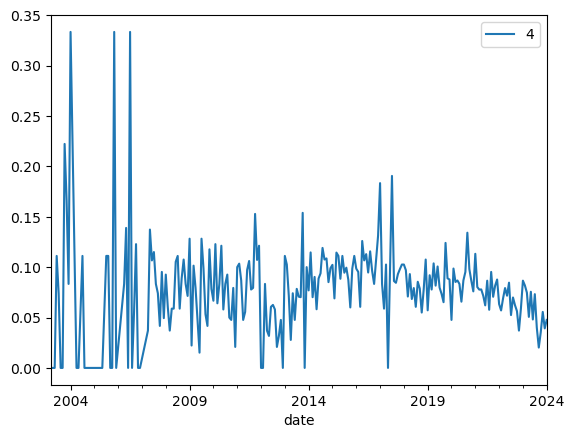

In [121]:
topic_df = pd.DataFrame(topics, columns=["1st_topic", "2nd_topic", "3rd_topic"])
news[["1st_topic", "2nd_topic", "3rd_topic"]] = topics
df_exploded = news.explode('topic')

# Group by month (year and month of the date) and topic, then count occurrences
topic_trends = df_exploded.groupby([df_exploded['date'].dt.to_period('M'), 'topic']).size().reset_index(name='count')

topic_trends = topic_trends.pivot(index="date", columns="topic", values="count").fillna(0)
total_news_per_month = topic_trends.sum(axis=1)

# Calculate the ratio of each topic's count to the total news items for each month
topic_ratio = topic_trends.div(total_news_per_month, axis=0)
topic_ratio.plot(y=4);

In [29]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

mallet_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_model)
vis_data = gensimvis.prepare(mallet_lda_model, corpus, id2word)
ldaviz_path = os.getcwd() + "/outputs/text/solomon_islands/sib_ldavis.html"
pyLDAvis.save_html(vis_data, ldaviz_path)
pyLDAvis.display(vis_data)

/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


## HDP/CTM

In [102]:
from gensim.models import CoherenceModel, HdpModel
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

[2024-03-12 16:55:46 - gensim.models.hdpmodel:674 - WARNING] likelihood is decreasing!
[2024-03-12 16:55:46 - gensim.models.hdpmodel:674 - WARNING] likelihood is decreasing!
[2024-03-12 16:55:46 - gensim.models.hdpmodel:674 - WARNING] likelihood is decreasing!


In [103]:
hdpmodel.show_topics()

[(0,
  '0.028*say + 0.018*government + 0.008*people + 0.005*development + 0.005*business + 0.005*support + 0.005*work + 0.004*economic + 0.004*project + 0.004*need + 0.004*include + 0.004*new + 0.004*public + 0.003*member + 0.003*add + 0.003*island + 0.003*provide + 0.003*time + 0.003*provincial + 0.003*national'),
 (1,
  '0.026*say + 0.018*government + 0.008*people + 0.007*development + 0.007*support + 0.006*project + 0.006*economic + 0.005*work + 0.005*business + 0.004*include + 0.004*need + 0.004*provide + 0.004*new + 0.004*community + 0.004*island + 0.004*service + 0.004*national + 0.003*woman + 0.003*provincial + 0.003*country'),
 (2,
  '0.027*say + 0.016*government + 0.007*people + 0.006*business + 0.005*work + 0.005*support + 0.005*project + 0.005*development + 0.004*economic + 0.004*provincial + 0.004*new + 0.003*include + 0.003*company + 0.003*community + 0.003*public + 0.003*service + 0.003*national + 0.003*report + 0.003*need + 0.003*provide'),
 (3,
  '0.010*say + 0.008*gove

In [104]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from corextopic import corextopic as ct
vectorizer = CountVectorizer(
    stop_words=spacy_stopwords,
    ngram_range=(1,3),
    binary=True
)

In [105]:
word_doc = vectorizer.fit_transform([" ".join(i) for i in texts][:1000])
word_doc = scipy.sparse.csr_matrix(word_doc)

In [106]:
keywords = [["economics", "development", "economy"], ["tourism", "visit"],
            ["community"], ["government", "politics", "election"],
            ["food", "price", "security", "inflation"], ["police"],
            ["labor", "job", "employment", "work"]]

In [107]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = vectorizer.vocabulary_.keys()

In [108]:
corrtopics_model = ct.Corex(n_hidden=len(keywords))
corrtopics_model.fit(word_doc, anchors=keywords, words=words)

In [110]:
topics = corrtopics_model.get_topics()
for n, topic in enumerate(topics):
    topic_words, _, _ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: commercial term international, agriculture product minister, organization compose melanesian, hotel ongoing, family force income, term international transit, marine jurisdiction threat, additional soon release, facilitation, benefit additional soon
1: connect mind, thank end, member import manufacture, encouraging youth create, formally convey, economy radioactive, party technical investment, engage province, right lot, plan establish
2: capacity believe, yesterday video footage, growth centre lead, high government, recession advisor geopolitical, start new, government capacity, consular service citizen, squander resource leave, national development objective
3: aim water, condolence people relative, time brief, new form partnership, carry mandate, embark initiative enable, assist teak, application noni honey, cash help, artefact music share
4: human_right time, korona consent add, approach development, high rate time, morning page officer, case approve, anticipate capacity developm